# Cell type classification demo

In [1]:
# Import libraries
import os
import numpy as np
import seaborn as sns
import scanpy as sc
import matplotlib.pyplot as plt

from tifffile import imread
from skimage.filters import threshold_otsu, gaussian
from skimage.morphology import remove_small_objects

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set up the paths
base_path = '/home/unix/jiahao/wanglab/Data/Analyzed/sample-dataset-output/tissue-2D'
output_path = os.path.join(base_path, 'output')
expr_path = os.path.join(base_path, 'expr')
image_path = os.path.join(base_path, 'images')
figure_path = os.path.join(base_path, 'figures')
if not os.path.exists(figure_path):
    os.mkdir(figure_path)

# Load the data 
adata = sc.read_h5ad(os.path.join(expr_path, '2023-11-27-mAD_64.h5ad'))
adata

AnnData object with n_obs × n_vars = 12258 × 64
    obs: 'area', 'x', 'y', 'seg_label'

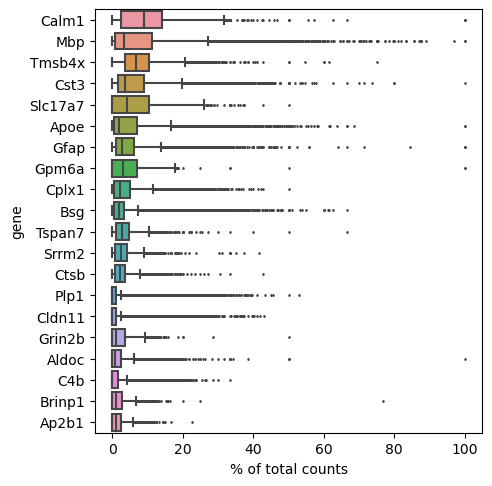

In [3]:
# Calculate the QC metrics
sc.pp.calculate_qc_metrics(adata, inplace=True, percent_top=None)
sc.pl.highest_expr_genes(adata, n_top=20)

In [4]:
# Preprocess the data
sc.pp.filter_cells(adata, min_counts=10)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.scale(adata)
adata.layers['scaled'] = adata.X.copy()

adata.shape

(12100, 64)

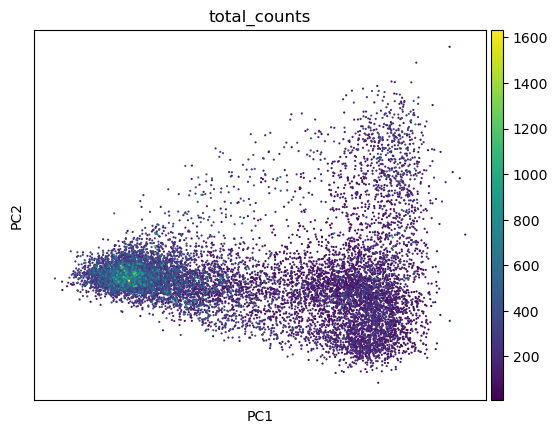

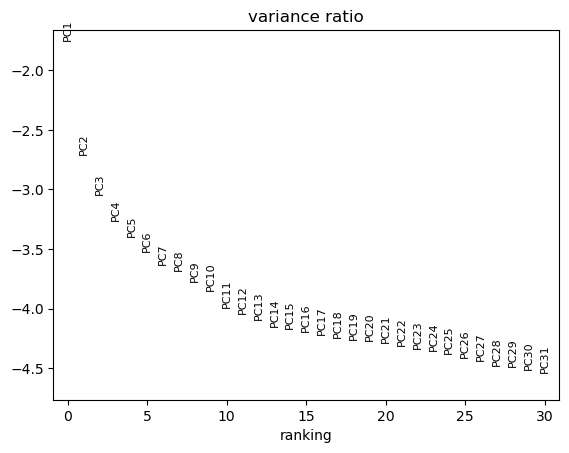

In [5]:
# PCA
sc.tl.pca(adata, svd_solver='full')
sc.pl.pca(adata, color='total_counts')
sc.pl.pca_variance_ratio(adata, log=True)   

2024-08-19 13:50:42.179057: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-19 13:50:42.215249: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-19 13:50:43.037986: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


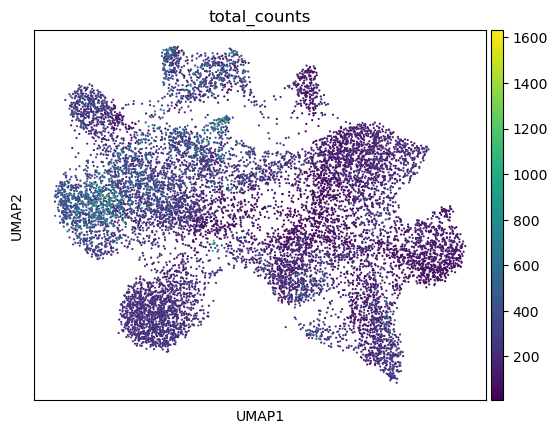

In [6]:
# Build KNN graph
n_neighbors = 50
n_pcs = 10
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs)

# UMAP
sc.tl.umap(adata)
sc.pl.umap(adata, color='total_counts')

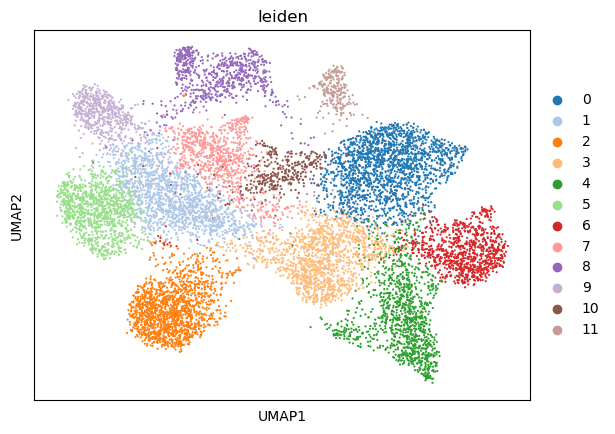

In [7]:
# Leiden clustering
resolution = .7
sc.tl.leiden(adata, resolution=resolution)

# Create color palette and plot UMAP
cpl = sns.color_palette('tab20', n_colors=adata.obs['leiden'].nunique())
sc.pl.umap(adata, color='leiden', palette=cpl)

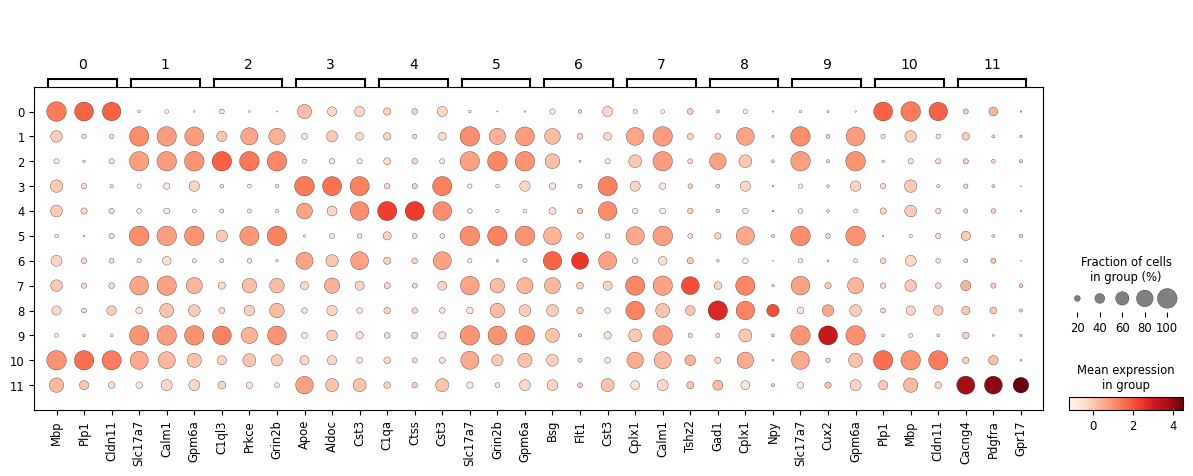

In [8]:
# Identify gene markers
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups_dotplot(adata, n_genes=3, dendrogram=False)

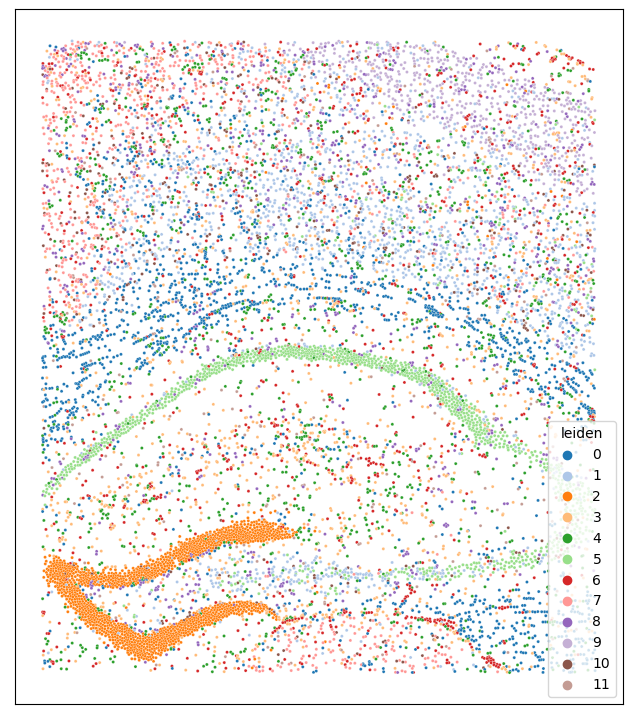

In [9]:
# Plot the spatial cell type map with leiden clustering
fig_size = np.array([adata.obs['x'].max(), adata.obs['y'].max()]) / 10000 * 4
fig, ax = plt.subplots(figsize=fig_size)
g = sns.scatterplot(x='x', y='y', hue='leiden', 
                    palette=cpl,
                    data=adata.obs, 
                    s=5,
                    ax=ax)
g.invert_yaxis()
g.axes.xaxis.set_visible(False)
g.axes.yaxis.set_visible(False)

In [10]:
# Create cell type annotation 
adata.obs['cell_type'] = adata.obs['leiden'].values

annotation_list = [
    'Oligodendrocyte', #0 
    'Excitatory neuron', #1
    'DG', #2
    'Astrocyte', #3
    'Microglia', #4
    'CA', #5
    'Endothelial cell', #6
    'Excitatory neuron', #7
    'Inhibitory neuron', #8
    'Excitatory neuron', #9
    'Oligodendrocyte', #10
    'Oligodendrocyte precursor cell', #11
]

# Construct transfer dict
annotation_dict = {}
for i in sorted(adata.obs['leiden'].unique()):
    annotation_dict[i] = annotation_list[int(i)]

# Assign cell type to sdata
adata.obs = adata.obs.replace({'cell_type': annotation_dict})

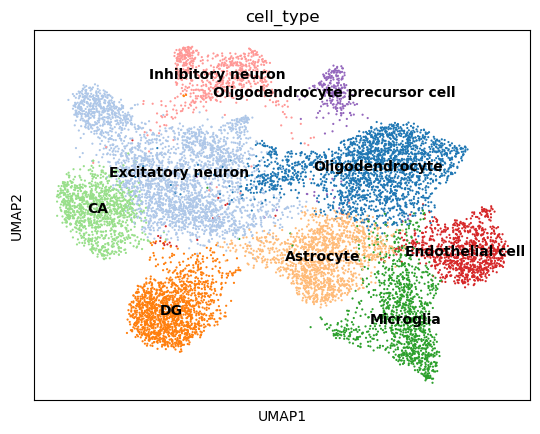

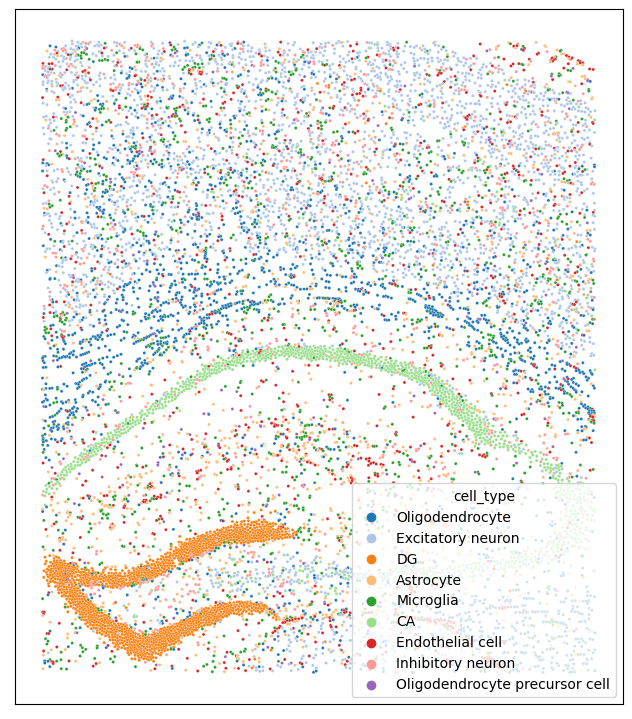

In [11]:
# Visualize the cell type annotation
sc.pl.umap(adata, color='cell_type', palette=cpl, legend_loc="on data")

# Plot the spatial cell type map with leiden clustering
fig_size = np.array([adata.obs['x'].max(), adata.obs['y'].max()]) / 10000 * 4
fig, ax = plt.subplots(figsize=fig_size)
g = sns.scatterplot(x='x', y='y', hue='cell_type', 
                    palette=cpl,
                    data=adata.obs, 
                    s=5,
                    ax=ax)
g.invert_yaxis()
g.axes.xaxis.set_visible(False)
g.axes.yaxis.set_visible(False)

In [12]:
# Remove object in image by size
def filter_objects_by_size(label_image, min_size=0, max_size=None):
    small_removed = remove_small_objects(label_image, min_size)
    if max_size is not None:
        mid_removed = remove_small_objects(small_removed, max_size)
        large_removed = small_removed.astype(np.float32) - mid_removed.astype(np.float32)
        large_removed = large_removed.astype(np.bool)
        return large_removed
    else:
        return small_removed

In [13]:
# Add protein images to object for further visualization & analysis
# Segmentation
current_sample_id = 'AD'

label_img = imread(os.path.join(image_path, 'fused/labeled_cells_05.tif'))

# Plaque (scaled down to 0.5)
plaque_img = imread(os.path.join(image_path, 'fused/plaque_05.tif'))
plaque_img = gaussian(plaque_img.astype(np.float), 2) > 50

# Tau (scaled down to 0.5)
tau_img = imread(os.path.join(image_path, 'fused/tau_05.tif'))
tau_img = gaussian(tau_img.astype(np.float), 2) > 50
tau_img = filter_objects_by_size(tau_img, min_size=10, max_size=500)
     
# Gfap (scaled down to 0.5)
gfap_img = imread(os.path.join(image_path, 'fused/Gfap_05.tif'))
gfap_threshold = threshold_otsu(gfap_img)
gfap_img = gaussian(gfap_img.astype(np.float), 1) > gfap_threshold

# Morph
current_key = f"{current_sample_id}_morph"
adata.uns[current_key] = {}
adata.uns[current_key]['label_img'] = label_img
adata.uns[current_key]['plaque'] = plaque_img
adata.uns[current_key]['tau'] = tau_img
adata.uns[current_key]['gfap'] = gfap_img

In [14]:
# Save the processed data
adata.write_h5ad(os.path.join(expr_path, '2023-11-27-mAD_64_cp.h5ad'))